
Columnas disponibles: ['Year', 'Month', 'Day', 'Time', 'Flight_Time_(s)', 'Sync', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Accel_X', 'Accel_Y', 'Accel_Z', 'Quat_1', 'Quat_2', 'Quat_3', 'Quat_4', 'Aux_Volts', 'Current']

Rango de tiempo: -2.024 a 179.614 s


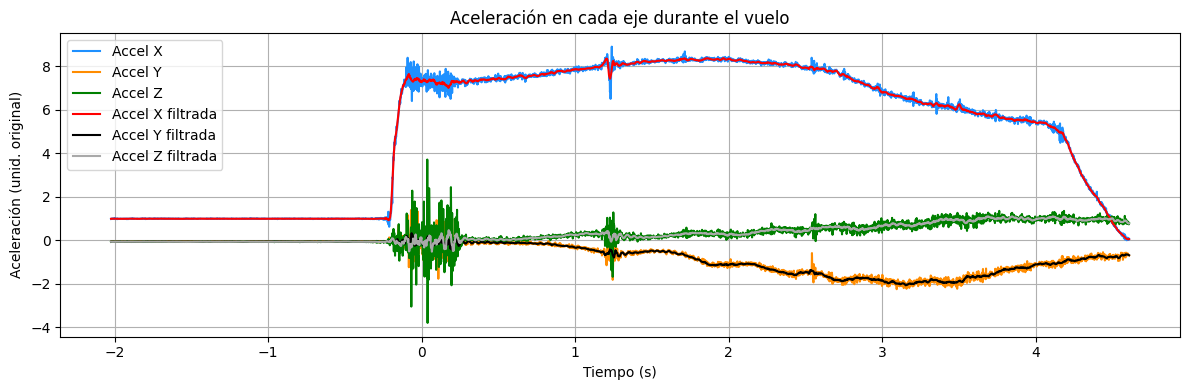

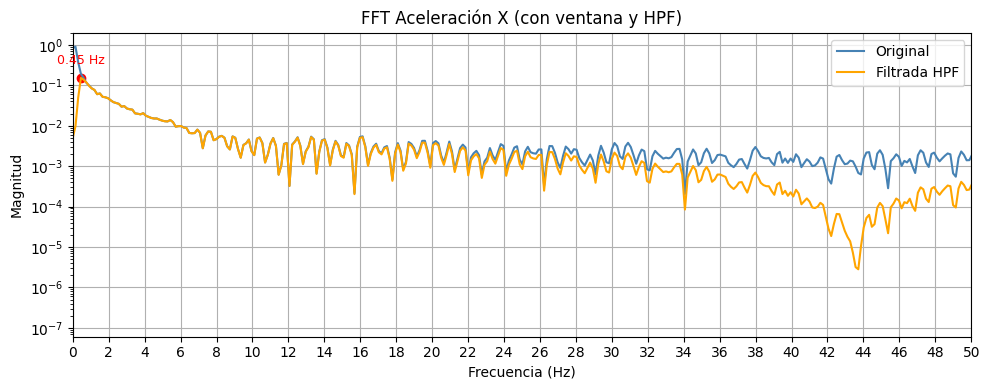

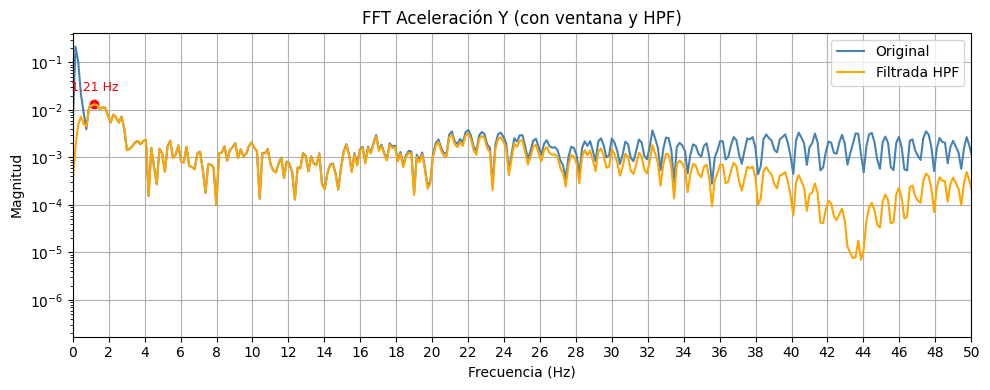

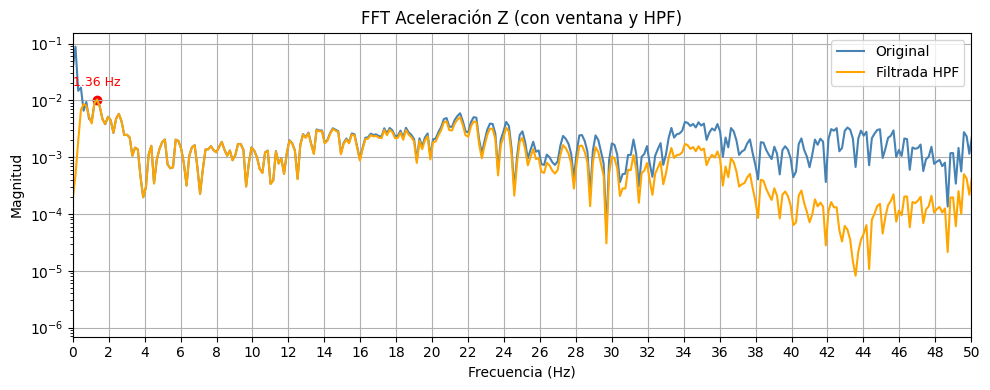

In [2]:
# Importación de las librerias necesairias para el desarrollo de los codigos 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter, get_window
from scipy.fft import fft, fftfreq
import os

# Carga y lectura del archivo CSV con los datos del vuelo
ruta_csv = "C:/Users/Luisa Fernanda/Downloads/BlueRav Volta HR_06-12-2025_16_30_38.csv"

if not os.path.exists(ruta_csv):
    raise FileNotFoundError(f"El archivo no fue encontrado en: {ruta_csv}")

df = pd.read_csv(ruta_csv)
df.columns = df.columns.str.strip()  # Limpieza a los nombres de columnas por si hay espacios

"""
Las siguientes 2 líneas se usan para explorar rápidamente el DataFrame y entender su estructura.
La primera imprime todas las columnas disponibles, lo cual ayuda a identificar qué variables hay.
La segunda muestra el rango de tiempo del vuelo, lo cual es útil para verificar la duración total
y establecer límites para el análisis de vibraciones u otros eventos."""

# Mostrar las columnas disponibles en el DataFrame para verificar qué datos contiene
print("\nColumnas disponibles:", df.columns.tolist())

# Mostrar el rango de tiempo registrado durante el vuelo, útil para definir intervalos de análisis
print("\nRango de tiempo:", df['Flight_Time_(s)'].min(), "a", df['Flight_Time_(s)'].max(), "s")


"""En el siguiente bloque de código se extraen  los datos de tiempo y aceleraciones desde el DataFrame df 
y se almacenan como arreglos de NumPy, lo cual facilita su análisis y procesamiento posterior"""

# Definición de variables de tiempo y aceleración según los encabezados del dataframe
t = df["Flight_Time_(s)"].values
accel_x = df["Accel_X"].values
accel_y = df["Accel_Y"].values
accel_z = df["Accel_Z"].values

"""Este siguiente bloque de código selecciona automáticamente nuestro intervalo de interés dentro de los datos del vuelo, 
especificamente va desde el inicio del vuelo hasta el primer instante en que la aceleración en X (Accel_X) se vuelve negativa (fin del vuelo)."""

# Se define intervalo de la muestra a analizar desde inicio hasta que Accel_X < 0
idx_fin = np.argmax(accel_x < 0) if np.any(accel_x < 0) else len(accel_x)
t_vuelo = t[:idx_fin]
accel_x = accel_x[:idx_fin]
accel_y = accel_y[:idx_fin]
accel_z = accel_z[:idx_fin]

"""Este bloque de código aplica un filtro de Savitzky-Golay a las señales de aceleración para suavizar los datos y eliminar ruido de alta frecuencia, 
como el causado por vibraciones aleatorias o errores del sensor, sin distorsionar demasiado la señal original.
Ideal para preprocesar señales antes de aplicar análisis espectral (como FFT)
"""
# Primer Filtro de Savitzky-Golay para los datos de aceleración para eliminar ruido
accel_x_sav_gol_1 = savgol_filter(accel_x, window_length=20, polyorder=3)
accel_y_sav_gol_1 = savgol_filter(accel_y, window_length=20, polyorder=3)
accel_z_sav_gol_1 = savgol_filter(accel_z, window_length=20, polyorder=3)

"""Se aplica por segunda vez para reforzar la atenuación del ruido"""
# Segundo Filtro Savitzky-Golay    (aplicar si se ve que con el primero no es suficiente)
#accel_x_sav_gol = savgol_filter(accel_x, window_length=50, polyorder=3)
#accel_y_sav_gol = savgol_filter(accel_y, window_length=50, polyorder=3)
#accel_z_sav_gol = savgol_filter(accel_z, window_length=50, polyorder=3)

"""Este bloque de código define la función del filtro pasa-altos y sus parametros, para luego aplicarlo para 
eliminar componentes de baja frecuencia de nuestra señal, como desplazamientos lentos, 
oscilaciones de fondo, o ruidos otro tipo y así no procesarlas como vibraciones"""

# Filtro pasa-altos (high pass)
def hpf(senal, fs, fc=0.4, orden=4):    #Se usa 0,4 Hz para eliminar bajas frecuencias pero no ignorar otras que puedan ser importantes
    w = fc / (fs / 2)
    b, a = butter(orden, w, btype='high')
    return filtfilt(b, a, senal)

"""Este código calcula la frecuencia de muestreo (fs) de los datos, es decir, cuántas muestras por segundo se están registrando en la señal de vuelo (t_vuelo). """
# Cálculo la frecuencia de muestreo a partir del tiempo
delta_t = np.mean(np.diff(t_vuelo))
fs = 1 / delta_t

# Aplicación del filtro hpf (pasa-altos) a cada señal de aceleración
accel_x_hp = hpf(accel_x_sav_gol_1, fs)
accel_y_hp = hpf(accel_y_sav_gol_1, fs)
accel_z_hp = hpf(accel_z_sav_gol_1, fs)

"""Este bloque de código realiza el análisis espectral de las señales de aceleración mediante 
la Transformada Rápida de Fourier (FFT), aplicando previamente una ventana de Hanning (Hann). 
Este enfoque permite observar la frecuencia de las vibraciones presentes en el vuelo del cohete 
y distinguir los componentes dominantes."""

# Aplicación de la transformada aplicando un método de windowing (Hanning o Hann) o ventaneo a la señal para volverla periódica y evitar fugas espectrales, esto se explica más a fondo en el informe
def calcular_fft(senal, delta_t):
    n = len(senal)
    ventana = get_window("hann", n)
    senal_win = (senal - np.mean(senal)) * ventana
    f = fftfreq(n, d=delta_t)
    mag = np.abs(fft(senal_win)) / n
    return f[:n//2], mag[:n//2]

# FFT para señales originales y filtradas
f_x, mag_x = calcular_fft(accel_x, delta_t)
f_x_hp, mag_x_hp = calcular_fft(accel_x_hp, delta_t)

f_y, mag_y = calcular_fft(accel_y, delta_t)
f_y_hp, mag_y_hp = calcular_fft(accel_y_hp, delta_t)

f_z, mag_z = calcular_fft(accel_z, delta_t)
f_z_hp, mag_z_hp = calcular_fft(accel_z_hp, delta_t)

"""Grafica para visualizar y comparar el espectro de frecuencias de una señal de aceleración antes y después de aplicar un filtro pasa-altos (hpf)"""

# Función para comparar espectros antes y después del filtro
def graficar_comparacion_fft(f, mag_orig, mag_filt, eje, fmax=50, step=2):
    plt.figure(figsize=(10, 4))
    plt.plot(f, mag_orig, label="Original", color='steelblue')
    plt.plot(f, mag_filt, label="Filtrada HPF", color='orange')
    plt.yscale('log')
    idx_max = np.argmax(mag_filt)
    f_pico = f[idx_max]
    mag_pico = mag_filt[idx_max]
    plt.scatter(f_pico, mag_pico, color='red')
    plt.annotate(f"{f_pico:.2f} Hz", (f_pico, mag_pico), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='red')
    plt.xlim(0, fmax)
    plt.xticks(np.arange(0, fmax + 1, step))
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.title(f"FFT Aceleración {eje} (con ventana y HPF)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

"""Grafica para visualizar las señales de aceleración en los tres ejes (X, Y y Z) 
a lo largo del tiempo y comparar las señales originales con las señales suavizadas mediante el filtro de Savitzky-Golay"""

# Función para graficar aceleración vs tiempo en cada eje
def graficar_aceleraciones(tiempo, ax, ay, az, accel_x_sav_gol_1, accel_y_sav_gol_1, accel_z_sav_gol_1):
    plt.figure(figsize=(12, 4))
    plt.plot(tiempo, ax, label="Accel X", color='dodgerblue')
    plt.plot(tiempo, ay, label="Accel Y", color='darkorange')
    plt.plot(tiempo, az, label="Accel Z", color='green')
    plt.plot(tiempo, accel_x_sav_gol_1, label="Accel X filtrada", color='red')
    plt.plot(tiempo, accel_y_sav_gol_1, label="Accel Y filtrada", color='black')
    plt.plot(tiempo, accel_z_sav_gol_1, label="Accel Z filtrada", color='darkgrey')
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Aceleración (unid. original)")
    plt.title("Aceleración en cada eje durante el vuelo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Gráfica para las aceleraciones vs tiempo
graficar_aceleraciones(t_vuelo, accel_x, accel_y, accel_z,accel_x_sav_gol_1, accel_y_sav_gol_1, accel_z_sav_gol_1)

"""Grafica para visualizar y comparar el contenido espectral (FFT) de las señales de aceleración en los tres ejes antes y después de aplicar el filtro """

#Gráficas de las FFT comparadas eje por eje
graficar_comparacion_fft(f_x, mag_x, mag_x_hp, "X")
graficar_comparacion_fft(f_y, mag_y, mag_y_hp, "Y")
graficar_comparacion_fft(f_z, mag_z, mag_z_hp, "Z")